In [6]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import shapely
import multiprocess as mp
import numpy as np
import igraph as ig
import ast


crs_fr = 2154


# Get data

In [10]:
#--- Get full baseline OD
# jobs = pd.read_csv('data/results/baseline_activepopdens.csv')
# jobs_0_5 = pd.read_csv('data/results/OD_jobs_delta_0.5.csv')
# jobs_1 = pd.read_csv('data/results/OD_jobs_delta_1.csv')
# jobs_1_5 = pd.read_csv('data/results/OD_jobs_delta_1.5.csv')
schools_base = pd.read_csv('data/results/edge_betweenness_baseline_school.csv').set_index('Edge')['Betweenness Centrality'].to_dict()
schools_0_5 = pd.read_csv('data/results/edge_betweenness_school_delta05.csv').set_index('Edge')['Betweenness Centrality'].to_dict()
schools_1 = pd.read_csv('data/results/edge_betweenness_school_delta1.csv').set_index('Edge')['Betweenness Centrality'].to_dict()
schools_1_5 = pd.read_csv('data/results/edge_betweenness_school_delta1.5.csv').set_index('Edge')['Betweenness Centrality'].to_dict()

# Create Network

In [11]:
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

In [12]:
#--- Create the network in NetworkX and move to igraph
# Retrieve edges
edges_with_id = pd.read_csv('data/clean/initial_network_edges.csv')
edges_with_id["geometry"] = edges_with_id.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_with_id = gpd.GeoDataFrame(edges_with_id, geometry = 'geometry', crs = 4326).to_crs(2154)
edges_with_id = edges_with_id.rename(columns={"id": "G"})

# Retrieve nodes
nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv')
nodes_carbike_centroids_RER_complete["geometry"] = nodes_carbike_centroids_RER_complete.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = 'geometry', crs = 2154)

# Create the attr_dict
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER,
                                                                  IRIS = x.CODE_IRIS,
                                                                  pop_dens = x.pop_density,
                                                                  active_pop_density = x.active_pop_density,
                                                                  school_pop_density = x.school_pop_density,
                                                                  num_schools = x.school_count,
                                                                  num_jobs = x.num_jobs,
                                                                  ),
                                                                  axis = 1) 

# Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

# TODO create g_igraph from file, and import nids and eids from file
#--- Moving from NetworkX to igraph
g_igraph = ig.Graph()
networkx_graph = G
g_igraph = ig.Graph.from_networkx(networkx_graph)

# eids: "conversion table" for edge ids from igraph to nx 
eids_nx = [g_igraph.es[i]["G"] for i in range(len(g_igraph.es))]
eids_ig = [i for i in range(len(g_igraph.es))]
eids_conv = pd.DataFrame({"nx": eids_nx, "ig": eids_ig})

# nids: "conversion table" for node ids from igraph to nx
nids_nx = [g_igraph.vs(i)["_nx_name"][0] for i in range(len(g_igraph.vs))]
nids_ig = [i for i in range(len(g_igraph.vs))]
nids_conv = pd.DataFrame({"nx": nids_nx, "ig": nids_ig})
nids_conv['nx'] = nids_conv['nx'].astype(int)

# combine the conversion table with nodes_carbike_centroids_RER_complete
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.merge(nids_conv, left_on = "osmid", right_on = "nx", how = "left")
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.drop(columns = ["nx"])

seq = g_igraph.vs.select(centroid_eq = True)
centroids = [v.index for v in seq]

# Calculate benefit metric

In [67]:
#--- Calculate benefit metric based on betweenness centrality
import ast
from functools import partial

def process_row(row, edge_lengths, edge_betweenness):  # for one csv
    try:
        row['path'] = ast.literal_eval(row['path'])
        row[str(key) + "_B_star"] = np.sum([edge_betweenness[edge] * edge_lengths[edge] for edge in row.path])
        row[str(key) + "_B"] = row[str(key) + "_B_star"] / row["length"]
        return row
    except Exception as e:
        print("Exception occurred at index:", row.name)
        print("Exception message:", str(e))
        return None

def process_chunk(chunk, edge_lengths, edge_betweenness):  # Pass edge_lengths and edge_betweenness as arguments
    processed_rows = [process_row(row, edge_lengths, edge_betweenness) for _, row in chunk.iterrows()]
    processed_chunk = pd.DataFrame(processed_rows)
    return processed_chunk

edge_betweenness_dict = {
            "schools_base": schools_base,
            "schools_0_5": schools_0_5,
            "schools_1": schools_1,
            "schools_1_5": schools_1_5
        }

final_result = []
if __name__ == '__main__':
    for key, value in edge_betweenness_dict.items():
        print(key)
        file_path = './data/clean/mygaps2_under80.csv'
        mygaps = pd.read_csv(file_path, nrows = 100, chunksize=10)

        edge_lengths = {edge.index: g_igraph.es[edge.index]["length"] for edge in g_igraph.es}

        num_processes = mp.cpu_count()
        

        with mp.Pool(processes=num_processes) as pool:
            edge_betweenness = value  # Get the edge_betweenness for the current dictionary
            process_func = partial(process_chunk, edge_lengths=edge_lengths, edge_betweenness=edge_betweenness)
            results = pool.map(process_func, mygaps)

        final_result.append(pd.concat(results))

combined_df = pd.concat(final_result, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

schools_base
schools_0_5
schools_1
schools_1_5


In [73]:
for col in ['schools_base_B', 'schools_0_5_B', 'schools_1_B', 'schools_1_5_B']:
    top1000_df_col = combined_df.sort_values(by = col, ascending=False).head(1000)
    globals()[f"top10_df_{col}"] = top1000_df_col

In [11]:
def get_path_coords(my_path, my_coorddict):
    pathcoords = []
    for edge_id in my_path:
        edge_coords = [(c[0], c[1]) for c in my_coorddict[tuple(edge_id)].coords]
        pathcoords.append(edge_coords)
    return(pathcoords) 


# change edge id to list of int
def convert_path_to_list(path_string):
    path_list = ast.literal_eval(path_string)
    return path_list
    
ced = nx.get_edge_attributes(G, "geometry") # coordinates of edges dictionary ced
ced = {tuple(sorted(key)): value for key, value in ced.items()}

# turn string to list
top1000_schools_baseline['path_nx'] = top100_schools_baseline['path_nx'].apply(convert_path_to_list)

# add coordinates for  plotting
top100_schools_baseline["gapcoord"] = top100_schools_baseline.apply(lambda x: get_path_coords(x.path_nx, ced), axis = 1)



NameError: name 'top100_schools_baseline' is not defined

In [ ]:
gdf = gpd.GeoDataFrame(edges_with_id) 
gdff = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete).set_crs(4326, allow_override = True).to_crs(2154)

# Plot results

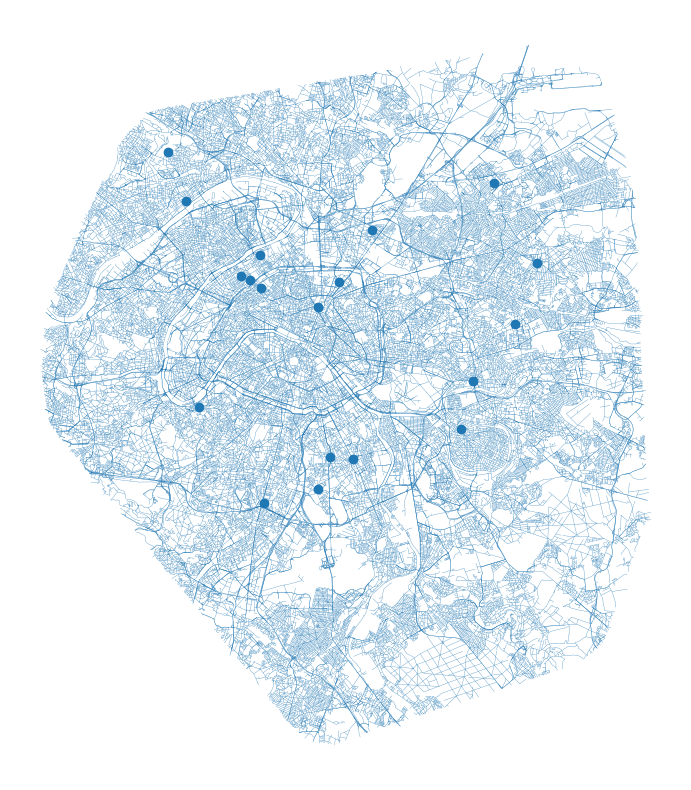

In [ ]:
def plot_edges(edges, ax, color):
    for edge in edges:
        x_vals, y_vals = zip(*edge)
        ax.plot(x_vals, y_vals, linestyle='-', linewidth=2, color=color)

# Create a single figure and axes to use throughout
fig, ax = plt.subplots(figsize=(10, 10))

# Plot gdf (assuming gdf is a GeoDataFrame)
gdf.plot(ax=ax, linewidth=0.2)
gdff.loc[gdff['ig'].isin(centroids[0:19])].plot(ax=ax)

# Plot edges from top10_FW with the specified color
# for i, row in top10_FW.iterrows():
#     plot_edges(row.gapcoord, ax, color='blue')

# # Plot edges from top10_PC with the same color
# for i, row in top10_PC.iterrows():
#     plot_edges(row.gapcoord, ax, color='red')
ax.axis('off')
ax.plot()
plt.show()

# matplotlib now also as PGF